# Football Leagues, Goals and Machine Learning

Football (soccer in the US) is, for the most part, extremely unpredictable - so much so that in the English Premier League, an underdog ran away with the title in the 2015/16 season. As a passionate follower of the sport, I started off by asking a question that had been lingering in mind for quite sometime - "Do home teams actually have an advantage?"


### Load the data

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.gridspec as gridspec
from numpy import random
import scipy.stats as scipy

from sklearn.metrics import accuracy_score

with sqlite3.connect('/home/sibi/Springboard/Data/database.sqlite') as con:
    countries = pd.read_sql_query("SELECT * from Country", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    leagues = pd.read_sql_query("SELECT * from League", con)
    teams = pd.read_sql_query("SELECT * from Team", con)
    tempmatch = pd.read_sql_query("SELECT * from Match", con)

In [3]:
#Subsetting the five countries of interest
main_countries = ['England','France','Germany','Italy','Spain']
countries = countries[countries.name.isin(main_countries)]
leagues = countries.merge(leagues,on='id',suffixes=('', '_y'))
seasons = matches.season.unique()
leagues

,id,name,country_id,name_y
0,1729,England,1729,England Premier League
1,4769,France,4769,France Ligue 1
2,7809,Germany,7809,Germany 1. Bundesliga
3,10257,Italy,10257,Italy Serie A
4,21518,Spain,21518,Spain LIGA BBVA


In [4]:
def res(row):
    if row['home_team_goal'] == row['away_team_goal']:
        val = 0
    elif row['home_team_goal'] > row['away_team_goal']:
        val = 1
    else:
        val = -1
    return val

In [5]:
#Merge the leagues with corresponding matches
req_matches = matches[matches.league_id.isin(leagues['id'])]
req_matches = req_matches[['id','league_id','home_team_api_id','away_team_api_id','home_team_goal','away_team_goal','season']]
req_matches["total_goals"] = req_matches['home_team_goal'] + req_matches['away_team_goal']
req_matches["result"] = req_matches.apply(res,axis = 1)
req_matches.dropna(inplace=True)
req_matches.head()

,id,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,season,total_goals,result
1728,1729,1729,10260,10261,1,1,2008/2009,2,0
1729,1730,1729,9825,8659,1,0,2008/2009,1,1
1730,1731,1729,8472,8650,0,1,2008/2009,1,-1
1731,1732,1729,8654,8528,2,1,2008/2009,3,1
1732,1733,1729,10252,8456,4,2,2008/2009,6,1


In [6]:
#Separating the leagues for plotting and further analysis
new_matches = pd.merge(req_matches,leagues,left_on='league_id', right_on='id')
new_matches = new_matches.drop(['id_x','id_y','country_id'],axis = 1)
english = new_matches[new_matches.name == "England"]
french = new_matches[new_matches.name == "France"]
italian = new_matches[new_matches.name == "Italy"]
spanish = new_matches[new_matches.name == "Spain"]
german = new_matches[new_matches.name == "Germany"]
# sum_goals = new_group_matches.home_team_goal.sum()
e = english.groupby('season')
f = french.groupby('season')
i = italian.groupby('season')
s = spanish.groupby('season')
g = german.groupby('season')
seasons

array([u'2008/2009', u'2009/2010', u'2010/2011', u'2011/2012',
       u'2012/2013', u'2013/2014', u'2014/2015', u'2015/2016'], dtype=object)

### How many goals does league score every season?

We start by investigating the trends in number of goals scored each season across leagues.

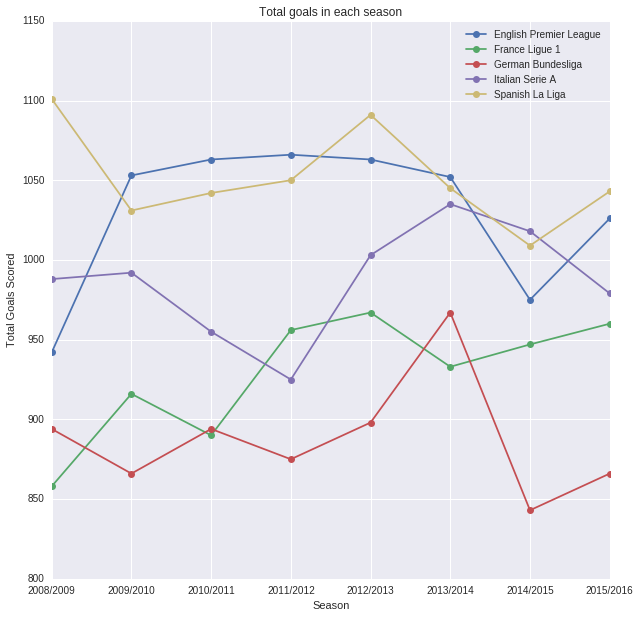

In [7]:
#Plotting total goals scored each season
fig = plt.figure(figsize=(10, 10))
plt.title("Total goals in each season")
plt.xticks(range(len(seasons)),seasons)
plt.style.use('ggplot')
plt.xlabel("Season")
plt.ylabel("Total Goals Scored")
num_seasons = range(len(seasons))
plt.plot(num_seasons,e.total_goals.sum().values,label = "English Premier League", marker = 'o')
plt.plot(num_seasons,f.total_goals.sum().values,label = "France Ligue 1", marker = 'o')
plt.plot(num_seasons,g.total_goals.sum().values,label = "German Bundesliga", marker = 'o')
plt.plot(num_seasons,i.total_goals.sum().values,label = "Italian Serie A", marker = 'o')
plt.plot(num_seasons,s.total_goals.sum().values,label = "Spanish La Liga", marker = 'o')
plt.legend()


The Spanish La Liga teams resort to much more aggressive tactics and formations every game as compared to the other leagues' teams. This, I believe, translates directly to more goals being scored than in other leagues.

Also, even though it might look like the Bundesliga teams scored fewer goals each season, it is to be remember that they play fewer games compared to teams from other leagues. In Bundesliga, there are only 18 teams playing each season and hence, they play a total of 306 games. In contrast, the other leagues have 20 teams and hence end up playing 380 games. 

Therefore, it would be a good idea to look at the average number of goals scored each game by season.

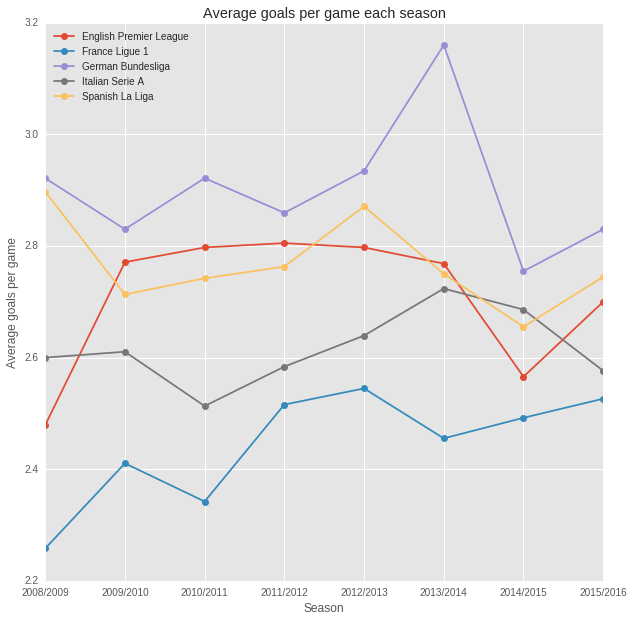

In [8]:
#Plotting average goals scored each season
fig = plt.figure(figsize=(10, 10))
plt.xticks(range(len(seasons)),seasons)
plt.style.use('ggplot')
plt.xlabel("Season")
plt.title("Average goals per game each season")
plt.ylabel("Average goals per game")
plt.plot(num_seasons,e.total_goals.mean().values,label = "English Premier League", marker = 'o')
plt.plot(num_seasons,f.total_goals.mean().values,label = "France Ligue 1", marker = 'o')
plt.plot(num_seasons,g.total_goals.mean().values,label = "German Bundesliga", marker = 'o')
plt.plot(num_seasons,i.total_goals.mean().values,label = "Italian Serie A", marker = 'o')
plt.plot(num_seasons,s.total_goals.mean().values,label = "Spanish La Liga", marker = 'o')
#plt.xlim = (-20,20)
plt.legend(loc = 2)


The Bundesliga teams score way more on average in each game that the teams in other leagues. In the 2013/2014 season, Bundesliga teams scored more than 3 goals each game on an average (967 goals in 306 matches - 3.16 per match). And teams in Ligue 1 have scored the least number of goals on a per game basis. 

### Investigating home team advantage?
There is always the conspicuous home team advantage in every sport but does it truly exist? Do teams really end up scoring more goals at their home stadium than when playing at an away fixture?

Let's try plotting number of goals scored at home (vs away) and subsequently the number of home wins. 

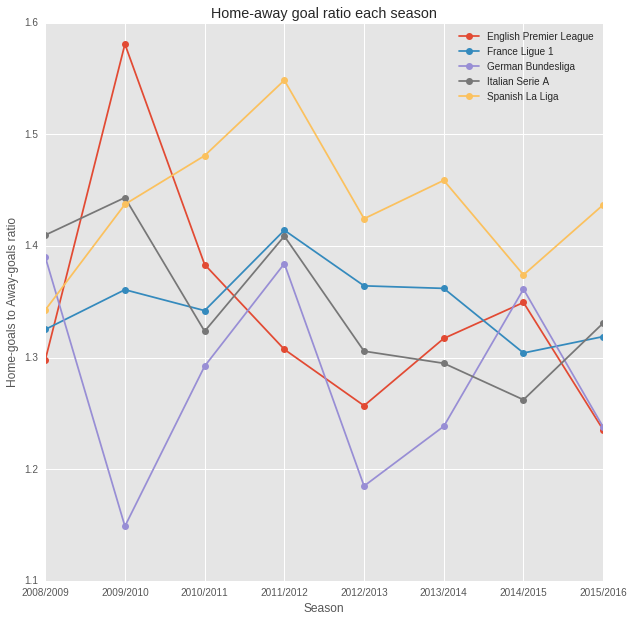

In [9]:
#Plotting home/away scored each season
fig = plt.figure(figsize=(10, 10))
plt.xticks(range(len(seasons)),seasons)
plt.style.use('ggplot')
plt.title('Home-away goal ratio each season')
plt.xlabel('Season')
plt.ylabel('Home-goals to Away-goals ratio')
plt.plot(num_seasons,e.home_team_goal.mean().values / e.away_team_goal.mean().values,label = "English Premier League", marker = 'o')
plt.plot(num_seasons,f.home_team_goal.mean().values / f.away_team_goal.mean().values,label = "France Ligue 1", marker = 'o')
plt.plot(num_seasons,g.home_team_goal.mean().values / g.away_team_goal.mean().values,label = "German Bundesliga", marker = 'o')
plt.plot(num_seasons,i.home_team_goal.mean().values / i.away_team_goal.mean().values,label = "Italian Serie A", marker = 'o')
plt.plot(num_seasons,s.home_team_goal.mean().values / s.away_team_goal.mean().values,label = "Spanish La Liga", marker = 'o')
#plt.xlim = (-20,20),
plt.legend(loc = 1)



In the last five seasons, La Liga teams have had a strong home advantage. This could be a key factor when they host teams from other leagues for European Leagues like the UEFA Championship or the Europa League. In such championship matches, there are usually two fixtures played (home and away) by each team. And since goals scored in each of these fixtures plays a role in teams qualifying to the next round, there seems to a big advantage to the La Liga teams in recent seasons.

The ratios for other leagues seem to vary significantly and not show any significant trends except the Bundesliga, again, which keeps oscillating between a strong home game and weak home game season. 

All the (home-goals/away-goals) ratios are above 1 and we can consistently see the ratio being above 1.3 for most leagues. This only shows that, on an average, teams score more at home fixtures than away. But how many of these matches do they win?

Again, since Bundesliga teams play 74 fewer games than the other league teams, let's plot the home-away win ratio for each league every season.

In [10]:
#Subsetting homewins vs homeloss from each of the leagues - ignoring draws.
e_hw = np.true_divide(english[english.result == 1].groupby('season').result.sum().values,english[english.result == -1].groupby('season').result.sum().values * -1)
f_hw = np.true_divide(french[french.result == 1].groupby('season').result.sum().values,french[french.result == -1].groupby('season').result.sum().values *-1)
g_hw = np.true_divide(german[german.result == 1].groupby('season').result.sum().values,german[german.result == -1].groupby('season').result.sum().values*-1)
i_hw = np.true_divide(italian[italian.result == 1].groupby('season').result.sum().values,italian[italian.result == -1].groupby('season').result.sum().values*-1)
s_hw = np.true_divide(spanish[spanish.result == 1].groupby('season').result.sum().values,spanish[spanish.result == -1].groupby('season').result.sum().values*-1)

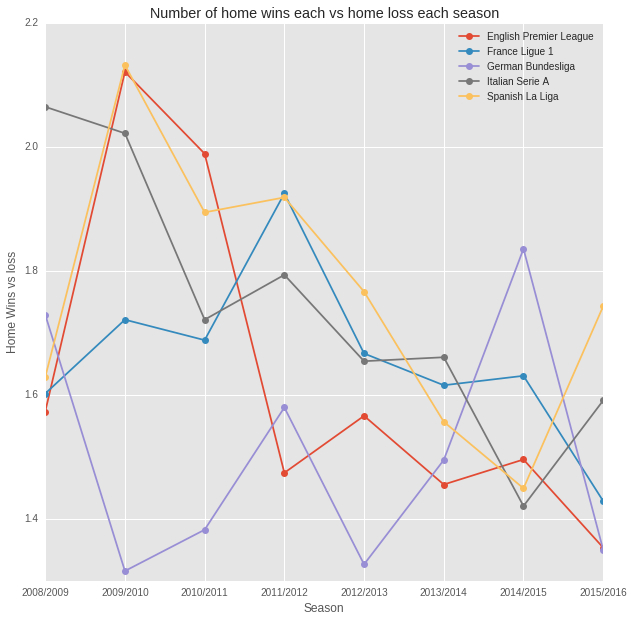

In [11]:
#Plotting number of home wins vs home losses each season
fig = plt.figure(figsize=(10, 10))
plt.xticks(range(len(seasons)),seasons)
plt.style.use('ggplot')
plt.xlim = (-20,20)
plt.ylim = (0,120)
plt.title("Number of home wins each vs home loss each season")
plt.xlabel("Season")
plt.ylabel("Home Wins vs loss")
plt.plot(num_seasons,e_hw,label = "English Premier League", marker = 'o')
plt.plot(num_seasons,f_hw,label = "France Ligue 1", marker = 'o')
plt.plot(num_seasons,g_hw,label = "German Bundesliga", marker = 'o')
plt.plot(num_seasons,i_hw,label = "Italian Serie A", marker = 'o')
plt.plot(num_seasons,s_hw,label = "Spanish La Liga", marker = 'o')
plt.legend(loc = 1)


We can see that a few leagues are winning fewer matches at home recently. In particular, there seems to be a steady decreasing trend in the French Ligue and the English Premier League. However, we are plotting only the home wins against the home losses and not taking draws into consideration. 

We could analyse the home-goals analysis for each team in the lague and also compare the ratio of number of home wins to home losses. In doing so, we could choose one of two things :
1. Include draw as a loss for the home team
2. Include draw as a win for the home team

In [12]:
def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2.0, 1*height,
                '%d' % int(height),
                ha='center', va='bottom')

In [13]:
#New dataframe merging home_team names and matches.
matches_w_teams = pd.merge(new_matches,teams,left_on='home_team_api_id', right_on='team_api_id')
matches_w_teams = matches_w_teams.drop(['id','team_api_id','team_fifa_api_id'],axis = 1)
matches_w_teams = matches_w_teams.rename(columns={'team_long_name':'home_team_long_name','name_y':'league_name','name':'country_name'})
matches_w_teams.head(1)

,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,season,total_goals,result,country_name,league_name,home_team_long_name,team_short_name
0,1729,10260,10261,1,1,2008/2009,2,0,England,England Premier League,Manchester United,MUN


In [14]:
#Color scheme for each country - from colourbrewer2.org
import matplotlib.patches as mpatches
colors = {'England':'#e41a1c', 'Spain':'#377eb8', 'Italy':'#4daf4a', 'France':'#984ea3', 'Germany':'#ff7f00'}
color = []

e = mpatches.Patch(color='#e41a1c', label='England')
s = mpatches.Patch(color='#377eb8', label='Spain')
it = mpatches.Patch(color='#4daf4a', label='Italy') #Facepalm note to self : never use i as it'll be used as an iterable for a for loop
f = mpatches.Patch(color='#984ea3', label='France')
g = mpatches.Patch(color='#ff7f00', label='Germany')


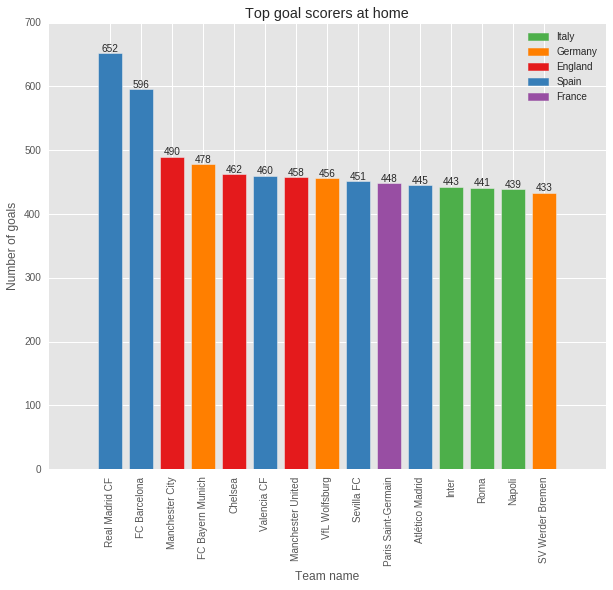

In [15]:
#Analysing teams in each league
top_n = 15
top_goal_scorers = matches_w_teams.groupby('home_team_long_name').total_goals.sum().sort_values(ascending = False)

for i in range(top_n):
    color.append([colors[t] for t in matches_w_teams[matches_w_teams.home_team_long_name == top_goal_scorers.head(top_n).index[i]].country_name.values][0])

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1)
rects = ax.bar(range(top_n), top_goal_scorers.head(top_n).values,align = "center",color = color)

ax.set_xticks(range(top_n))
ax.set_xticklabels(top_goal_scorers.head(top_n).index,rotation = "vertical")
ax.set_title("Top goal scorers at home")
ax.set_ylabel("Number of goals")
ax.set_xlabel("Team name")

ax.legend([it,g,e,s,f], colors.keys())
autolabel(rects)


Again, we see the dominance by the two big Spanish teams (Real Madrid and Barcelona) in scoring goals at home. The next competitor, Manchester City(490) is nearly a 100 goals behind FC Barcelona(596). And Real Madrid(652) leads the race ahead of its nearest competitor (and fierce rival), FC Barcelona, by 56 goals. 

Apart from this, we also notice that 5 of the top 15 teams are from Spain. England, Italy, Germany have three teams each and France has just the one big-spending club, Paris Saint-Germain in the top 15. 

It would be interesting to also look at the ratio of home wins to home losses for teams and compare it with this graph.

In [16]:
#We get teams' home win vs home loss ratio
team_home_win = matches_w_teams[matches_w_teams.result == 1].groupby('home_team_long_name').result.sum().sort_index()
team_home_loss = matches_w_teams[matches_w_teams.result ==  -1].groupby('home_team_long_name').count().result.sort_index()
team_home_draw_loss = matches_w_teams[matches_w_teams.result !=  1].groupby('home_team_long_name').count().result.sort_index()
team_home_draw_win =  matches_w_teams[matches_w_teams.result !=  -1].groupby('home_team_long_name').count().result.sort_index()
np.setdiff1d(team_home_loss.index,team_home_win.index)

#We notice that a team "SpVgg Greuther Furth" never won a home game in the one season it played in Germany. Remove it.
team_home_loss = team_home_loss[team_home_loss.index.str.contains("SpV") == False]
team_home_draw_win = team_home_draw_win[team_home_draw_win.index.str.contains("SpV") == False]

team_home_wl_ratio = team_home_win /team_home_loss
team_home_wl_ratio = team_home_wl_ratio.sort_values(ascending = False)
#print team_home_wl_ratio.head()

team_home_wld_ratio = team_home_win / team_home_draw_loss
team_home_wld_ratio = team_home_wld_ratio.sort_values(ascending = False)
#team_home_wld_ratio.head()

team_home_wdl_ratio = team_home_draw_win / team_home_loss
team_home_wdl_ratio = team_home_wdl_ratio.sort_values(ascending = False)


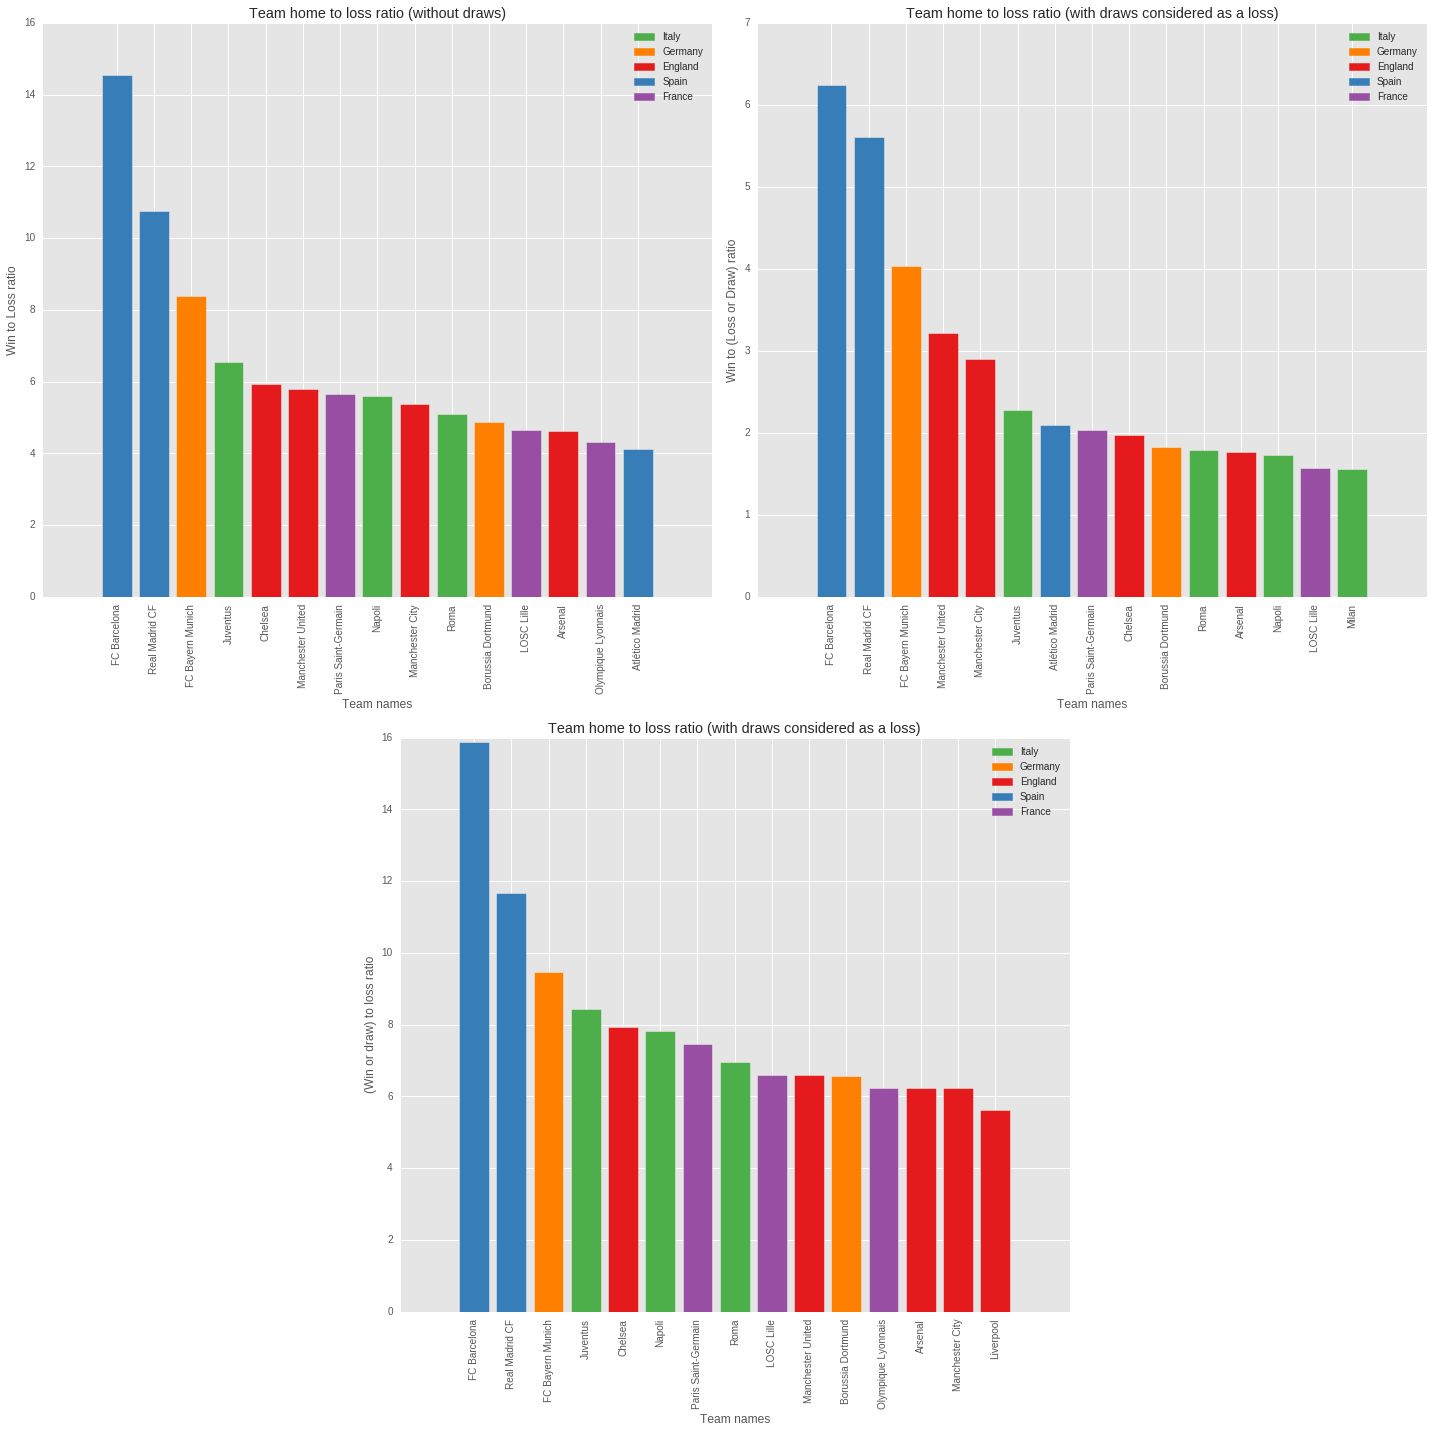

In [17]:
#Plotting top_n ratios
fig = plt.figure(figsize = (20,20))
plt.style.use('ggplot')

colorwl = []
colorwld = []
colorwdl = []
for i in range(top_n):
    colorwl.append([colors[t] for t in matches_w_teams[matches_w_teams.home_team_long_name == team_home_wl_ratio.head(top_n).index[i]].country_name.values][0])
    colorwld.append([colors[t] for t in matches_w_teams[matches_w_teams.home_team_long_name == team_home_wld_ratio.head(top_n).index[i]].country_name.values][0])
    colorwdl.append([colors[t] for t in matches_w_teams[matches_w_teams.home_team_long_name == team_home_wdl_ratio.head(top_n).index[i]].country_name.values][0])

gs = gridspec.GridSpec(2, 4)
ax1 = fig.add_subplot(gs[0, :2],)
rects1 = ax1.bar(range(top_n), team_home_wl_ratio.head(top_n).values,align = "center", color = colorwl)
ax1.set_xticks(range(top_n))
ax1.set_xticklabels(team_home_wl_ratio.head(top_n).index,rotation = "vertical")
ax1.set_title("Team home to loss ratio (without draws)")
ax1.set_ylabel("Win to Loss ratio")
ax1.set_xlabel("Team names")
ax1.legend([it,g,e,s,f], ["Italy","Germany","England","Spain","France"])

ax2 = fig.add_subplot(gs[0, 2:])
rects2 = ax2.bar(range(top_n), team_home_wld_ratio.head(top_n).values,align = "center", color = colorwld)
ax2.set_xticks(range(top_n))
ax2.set_xticklabels(team_home_wld_ratio.head(top_n).index,rotation = "vertical")
ax2.set_title("Team home to loss ratio (with draws considered as a loss)")
ax2.set_ylabel("Win to (Loss or Draw) ratio")
ax2.set_xlabel("Team names")
ax2.legend([it,g,e,s,f], ["Italy","Germany","England","Spain","France"])

ax3 = fig.add_subplot(gs[1,1:3])
rects3 = ax3.bar(range(top_n), team_home_wdl_ratio.head(top_n).values,align = "center", color = colorwdl)
ax3.set_xticks(range(top_n))
ax3.set_xticklabels(team_home_wdl_ratio.head(top_n).index,rotation = "vertical")
ax3.set_title("Team home to loss ratio (with draws considered as a loss)")
ax3.set_ylabel("(Win or draw) to loss ratio")
ax3.set_xlabel("Team names")
ax3.legend([it,g,e,s,f], ["Italy","Germany","England","Spain","France"])
plt.tight_layout()

Keeping with the trends, the two giants enjoy a considerably large (11 to 14) home win to loss ratio. Even if we consider draws, FC Barcelona and Real Madrid win at least 5 times more games at home than lose or draw. Following these two is FC Bayern Munich (from Germany) which also wins 4 times more than lose or draw at home.

Other big teams in the top 15 also have significantly large (4+) home win to loss ratio. However, the home win to (loss or draw) ratio is slightly lower (1.5 to 4) for these teams. Also, we can see that if we carried out the analyses by considering a draw to the number of wins list as opposed to the loss list, we get a much higher ratio (FC Barcelona nearly equal to 16).

These factors indicate that the top teams enjoy a very high home advantage. We could probably look at trends in each season and check how select teams are performing on this home-advantage factor.

We should also analyse how other teams at the bottom of the table perform on these factors. 

## Predictability across leagues

We know that football is a highly unpredictable game but how unpredictable is it really? Are there any differences between leagues in this regard?

From the dataset, we get the prior odds of a home win, draw and away win for each match given by Bet365, a popular betting agency. I believe that these odds captures information that cannot really be quantified; information such as a change in manager, general sentiment towards a team and its form, arrival of a new star player etc. 

By converting the odds to probabilities and calculating entropy (a measure of randomness used in information theory and in decision trees), we try to guage the randomness in the occurrence of the three results (home win, draw, away).

In [18]:
matches = matches[matches.league_id.isin(leagues.id)]
matches = matches[['id', 'country_id' ,'league_id', 'season', 'stage', 'date','match_api_id', 'home_team_api_id', 'away_team_api_id','B365H', 'B365D' ,'B365A']]
matches.dropna(inplace=True)
# matches.head()

#### Entropy function for each match

In [19]:
from scipy.stats import entropy


def match_entropy(row):
    odds = [row['B365H'],row['B365D'],row['B365A']]
    #change odds to probability
    probs = [1/o for o in odds]
    #normalize to sum to 1
    norm = sum(probs)
    probs = [p/norm for p in probs]
    return entropy(probs)

matches['entropy'] = matches.apply(match_entropy,axis=1)

#### Mean entropy for each season

In [ ]:
mean_ent = matches.groupby(('season','league_id')).entropy.mean()
mean_ent = mean_ent.reset_index().pivot(index='season', columns='league_id', values='entropy')
mean_ent.columns = [leagues[leagues.id==x].name.values[0] for x in mean_ent.columns]
mean_ent.head(10)

,England,France,Germany,Italy,Spain
season,,,,,
2008/2009,0.984556,1.026638,1.004276,1.002201,1.010859
2009/2010,0.956496,1.013821,0.997925,1.006755,0.977810
2010/2011,0.983258,1.026236,1.016264,1.006029,0.975032
2011/2012,0.969593,1.024915,1.001298,1.003077,0.955339
2012/2013,0.981472,1.016116,0.993993,1.003565,0.970580
2013/2014,0.960473,1.004439,0.977500,0.992622,0.944218
2014/2015,0.980301,1.012495,0.985835,0.999100,0.933637
2015/2016,0.997819,1.013928,0.974657,0.985284,0.946813


In [ ]:
ax = mean_ent.plot(figsize=(12,8),marker='o')
plt.title('Leagues Predictability', fontsize=16)
plt.xticks(rotation=50)

colors = [x.get_color() for x in ax.get_lines()]
colors_mapping = dict(zip(leagues.id,colors))

ax.set_xlabel('Mean Entropy')
plt.legend(loc='lower left')

ax.annotate('less predictable', xy=(7.3, 1.028), annotation_clip=False,fontsize=14,rotation='vertical')
ax.annotate('more predictable', xy=(7.3, 0.952), annotation_clip=False,fontsize=14,rotation='vertical')


This graph shows that the Spanish league is very predictable as compared to the other leauges. This is expected because since the 1950s, two teams (Barcelona and Real Madrid) have dominated the league winning 55 times among them. 

On the other hand, the English Premier League has become less predictable in recent times (Leicester City winning the title!) and previously dominant teams(Manchester United, Liverpool) losing their strength. 

#### Teamwise Analysis

In [ ]:
from matplotlib.lines import Line2D


barcelona = teams[teams.team_long_name=='Barcelona'].team_api_id.values
offsets = [-0.16,-0.08,0,0.08,0.16]
offsets_mapping = dict(zip(colors_mapping.keys(),offsets))
y = []
x = []
c = []

i = -1
for season,season_df in matches.groupby('season'):
    i+=1
    for team,name in zip(teams.team_api_id,teams.team_long_name):
        team_df = season_df[(season_df.home_team_api_id==team)|(season_df.away_team_api_id==team)]
        team_entropy = team_df.entropy.mean()
        if team_entropy>0:
            league_id = team_df.league_id.values[0]
            x.append(i+offsets_mapping[league_id])
            y.append(team_entropy)
            c.append(colors_mapping[league_id])


In [ ]:

plt.figure(figsize=(14,8))

plt.scatter(x,y,color=c,s=[40]*len(x))
plt.title('Teams Predictability', fontsize=16)

ax = plt.gca()
plt.xlim = (-0.5,7.5)
plt.xticks(np.arange(0,8,1),rotation=50)
ax.set_ylabel("Entropy")

ax.set_xticklabels(mean_ent.index)
for i in range(7):
    ax.axvline(x=0.5+i,ls='--',c='w')
ax.yaxis.grid(False)
ax.xaxis.grid(False)

circles = []
labels = []
for league_id,name in zip(leagues.id,leagues.name):
    labels.append(name)
    circles.append(Line2D([0], [0], linestyle="none", marker="o", markersize=6, markerfacecolor=colors_mapping[league_id]))
plt.legend(circles, labels, numpoints=3, loc=(0.005,0.02))


ax.annotate('', xytext=(7.65, 0.93),xy=(7.65, 1.1), arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1))
ax.annotate('', xytext=(7.65, 0.77),xy=(7.65, 0.6), arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1))

ax.annotate('less predictable', xy=(7.75, 1.05), annotation_clip=False,fontsize=14,rotation='vertical')
ax.annotate('more predictable', xy=(7.75, 0.73), annotation_clip=False,fontsize=14,rotation='vertical')

#add labels
ax.annotate('Barcelona', xy=(6.55, 0.634),fontsize=9)
ax.annotate('B. Munich', xy=(6.5, 0.655),fontsize=9)
ax.annotate('Real Madrid', xy=(6.51, 0.731),fontsize=9)
ax.annotate('PSG', xy=(6.93, 0.78),fontsize=9)


Again, quite expectedly, Barcelona and Real Madrid are near outliers along with Bayern Munich. These teams are very predictable in the sense that they're always expected to win. PSG follow closely in the list. 

## Predicting scores through Poisson Regression

Poisson Distribution, coupled with historical data, can provide a method for calculating the likely number of goals that will be scored in a soccer match. 

From historic data, we calculate features such as a team's attacking strength and defensive strength(home and away) based on the number of wins the team has at home and away. This simple method lets us calculate the probability of an outcome in any given fixture. 

### Load the data

In [ ]:
df = pd.read_csv("../Data/England/E0_13.csv")
df_14 = pd.read_csv("../Data/England/E0_14.csv")

### Cleaning

We do not need information about division, data, referee and betting odds from various companies for this method. 

In [ ]:
res_13 = df.ix[:,:23]
res_13 = res_13.drop(['Div','Date','Referee'],axis=1)
res_14 = df_14.ix[:,:23]
res_14 = res_14.drop(['Div','Date','Referee'],axis=1)
bet_13 = df.ix[:,23:]

### Dataframe to store the final league standings in 2013-14

We create a table with the goals scored, conceded, attacking strength, defensive strength of both teams.

Number of matches played at home = 19

Attacking strength at home (HAS) = (Goals scored at home / 19) / Average Number of goals at home in the season 

Defensive strength at home (HAS) = (Goals conceded at home / 19) / Average Number of goals conceded at home in the season 


In [ ]:
#Team, Home Goals Score, Away Goals Score, Attack Strength, Home Goals Conceded, Away Goals Conceded, Defensive Strength
table_13 = pd.DataFrame(columns=('Team','HGS','AGS','HAS','AAS','HGC','AGC','HDS','ADS'))

In [ ]:
avg_home_scored_13 = res_13.FTHG.sum() / 380.0
avg_away_scored_13 = res_13.FTAG.sum() / 380.0
avg_home_conceded_13 = avg_away_scored_13
avg_away_conceded_13 = avg_home_scored_13
print "Average number of goals at home",avg_home_scored_13
print "Average number of goals away", avg_away_scored_13
print "Average number of goals conceded at home",avg_away_conceded_13
print "Average number of goals conceded away",avg_home_conceded_13


In [ ]:
res_home = res_13.groupby('HomeTeam')
res_away = res_13.groupby('AwayTeam')

In [ ]:
table_13.Team = res_home.HomeTeam.all().values
table_13.HGS = res_home.FTHG.sum().values
table_13.HGC = res_home.FTAG.sum().values
table_13.AGS = res_away.FTAG.sum().values
table_13.AGC = res_away.FTHG.sum().values
table_13.HAS = (table_13.HGS / 19.0) / avg_home_scored_13
table_13.AAS = (table_13.AGS / 19.0) / avg_away_scored_13
table_13.HDS = (table_13.HGC / 19.0) / avg_home_conceded_13
table_13.ADS = (table_13.AGC / 19.0) / avg_away_conceded_13

#Team, Home Goals Score, Away Goals Score, Attack Strength, Home Goals Conceded, Away Goals Conceded, Defensive Strength
table_13.head()

In [ ]:
#Expected number of goals based on the average poisson probability
def exp_goals(mean):
    max_pmf = 0;
    for i in xrange(7):
        pmf = scipy.distributions.poisson.pmf(i,mean) * 100 
        if pmf > max_pmf:
            max_pmf = pmf
            goals = i
    return goals

In [ ]:
test_13 = res_13.ix[:,0:5]
test_13.head()
test_14 = res_14.ix[:,0:5]
test_14.head()

In [ ]:
table_13[table_13['Team'] == 'Arsenal']
test_14['ER'] = ''
test_14 = test_14.drop(test_14.index[380],axis=0)

In [ ]:
results = []
for index, row in test_13.iterrows():

    home_team = table_13[table_13['Team'] == row['HomeTeam']]
    away_team = table_13[table_13['Team'] == row['AwayTeam']]
    #print "Home : ", home_team.HAS.values, "Away: ", away_team.AAS.
    if row.HomeTeam not in ['Leicester', 'QPR', 'Burnley'] and row.AwayTeam not in ['Leicester', 'QPR', 'Burnley']:
        EH = home_team.HAS.values * away_team.ADS.values * avg_home_scored_13
        EA = home_team.HDS.values * away_team.AAS.values * avg_home_conceded_13
        #print row.HomeTeam, row.AwayTeam
        if EH[0] > EA[0]:
            results.append('H')
        else:
            results.append('A')
    else:
        results.append('D')
test_13['ER'] = results
accuracy_score(test_13['ER'],test_13['FTR'])

### Predicting the number of goals

Taking two sample teams, we predict the probability of number of goals that they might score in this fixture.


In [ ]:
team_1 = 'Man United'
team_2 = 'Cardiff'

home_team = table_13[table_13['Team'] == team_1]
away_team = table_13[table_13['Team'] == team_2]
EH = home_team.HAS.values * away_team.ADS.values * avg_home_scored_13
EA = home_team.HDS.values * away_team.AAS.values * avg_home_conceded_13

In [ ]:
def exp_goals_prob(mean):
    max_pmf = 0;
    prob = []
    for i in xrange(0,6):
        pmf = scipy.distributions.poisson.pmf(i,mean) * 100 
        prob.append(pmf[0])
    return prob

In [ ]:
prob_goals = pd.DataFrame(columns=['Team','0','1','2','3','4','5'])
home_team_prob = exp_goals_prob(EH)
away_team_prob = exp_goals_prob(EA)

In [ ]:
prob_goals.loc[0,1:] = home_team_prob
prob_goals.loc[1,1:] = away_team_prob
prob_goals.iloc[0,0] = team_1
prob_goals.iloc[1,0] = team_2
prob_goals

To calculate the probability that the expected score is 2-2, we simply multiply the probability that team_1 scores 2 goals and team_2 scores 2 goals. In this case, it comes out to 2.57%. 

Similarly, if we want to calculate the possibility of a draw, we calculate the probability of each draw first (0-0, 1-1, 2-2) etc. and add them all together. 

Straightaway, such an analysis lends itself to efficient betting. There are different kinds like home win, draw, away win, over 2.5 goals, under 2.5  goals etc. We could calculate the probabilities of each of this happening through Poisson Regression.

Performing this analysis for different leagues, it can be observed that for a few teams, the expected goal metric gives accuracte prediction of results. However, for other teams, it keeps wavering due to the inherent unpredictable nature of football.

## Prediction of the final result as a multiclass classification problem

Instead of trying to predict the scores in a given fixture, we can try to predict the final outcome - home win, draw or a home loss. This becomes a multiclass classification problem and we can try out different machine learning methods to model the data that we have. 

The objective would be to compare a model between different leagues and perform feature engineering to improve existing models.

In [ ]:
#Extract necessary features from the data file
feature_table = df.ix[:,:23]

#Full Time Result(FTR), Home Shots on Target(HST), Away Shots on Target(AST), Home Corners(HC), Away Corners(AC)
feature_table = feature_table[['HomeTeam','AwayTeam','FTR','HST','AST','HC','AC']]

#Home Attacking Strength(HAS), Home Defensive Strength(HDS), Away Attacking Strength(AAS), Away Defensive Strength(ADS)
f_HAS = []
f_HDS = []
f_AAS = []
f_ADS = []
for index,row in feature_table.iterrows():
    f_HAS.append(table_13[table_13['Team'] == row['HomeTeam']]['HAS'].values[0])
    f_HDS.append(table_13[table_13['Team'] == row['HomeTeam']]['HDS'].values[0])
    f_AAS.append(table_13[table_13['Team'] == row['AwayTeam']]['AAS'].values[0])
    f_ADS.append(table_13[table_13['Team'] == row['AwayTeam']]['ADS'].values[0])

feature_table['HAS'] = f_HAS
feature_table['HDS'] = f_HDS
feature_table['AAS'] = f_AAS
feature_table['ADS'] = f_ADS

In [ ]:
#Function to transform FTR into numeric data type
def transformResult(row):
    if(row.FTR == 'H'):
        return 1
    elif(row.FTR == 'A'):
        return -1
    else:
        return 0

In [ ]:
feature_table["Result"] = feature_table.apply(lambda row: transformResult(row),axis=1)

## Learning with new features

Initially, we add just the teams' attacking strength, defensive strength as features. In the second try, we also add the number of shots on target and the number of corners taken by both teams. This might be a good indication of teams scoring more goals and winning the game. We see an increase in the accuracy of the classifier after these new features are added into the model.

Since there are three possible results to any given fixture, with a Random Benchmark Model where we randomly pick on of the three outcomes as the final result, we will end up with an overall accuracy of 33%. On careful feature engineering, we will try to improve the model to give a much better accuracy.

In [ ]:
#Two sets of training sets - adding features.
X_train = feature_table[['HAS','HDS','AAS','ADS']]
X_train_2 = feature_table[['HAS','HDS','AAS','ADS','HST','AST','HC','AC']]
y_train = feature_table['Result']

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
clf = [DecisionTreeClassifier(),RandomForestClassifier(), KNeighborsClassifier(n_neighbors=17), MultinomialNB(),XGBClassifier()]
labels = ['D-Tree','RF','KNN', 'Naive Bayes','XGBoost']
mean_scores = []
mean_scores_2 = []
cms = []
for i in xrange(0,5):
    clf[i].fit(X_train,y_train)
    clf[i].fit(X_train_2,y_train)

    scores = cross_val_score(clf[i], X_train, y_train, cv=10)
    scores_2 = cross_val_score(clf[i], X_train_2, y_train, cv=10)
    print labels[i]," : ", scores.mean(), " : ", scores_2.mean()
    
    mean_scores.append(scores.mean())  
    mean_scores_2.append(scores_2.mean())


fig = plt.figure(figsize = (12,10))

ax = fig.add_subplot(2,2,1)

ax.bar(xrange(0,5),mean_scores,align='center');
ax.set_xticks(range(5));
ax.set_xticks(range(5));
ax.set_ylim(0,1);
ax.set_ylabel("Accuracy")
ax.set_title("Training Set 1 - shots,corners not included")
ax.set_xticklabels(labels);

ax2 = fig.add_subplot(2,2,2);
ax2.bar(xrange(0,5),mean_scores_2,align='center');
ax2.set_xticks(range(5))
ax2.set_ylabel("Accuracy")
ax2.set_ylim(0,1);
ax2.set_title("Training Set 2 - shots,corners included")
ax2.set_xticklabels(labels);

In [ ]:
#Plotting Confusion Matrix for select classifiers
fig = plt.figure(figsize = (10,8))
plt.style.use('ggplot')
gs = gridspec.GridSpec(2, 4)

#RandomForest
ax1 = fig.add_subplot(gs[0, :2],)
y_pred = clf[1].predict(X_train_2)
confusion_matrix(y_train, y_pred)
conf = pd.DataFrame(confusion_matrix(y_train, y_pred),columns=("Home Win","Draw","Away Win"),index=("Home Win", "Draw","Away Win"))
sns.heatmap(conf,annot=True,fmt='d')
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Actual")
ax1.set_title("Random Forest",fontsize=20)

#KNN
ax2 = fig.add_subplot(gs[0, 2:])
y_pred = clf[2].predict(X_train_2)
confusion_matrix(y_train, y_pred)
conf = pd.DataFrame(confusion_matrix(y_train, y_pred),columns=("Home Win","Draw","Away Win"),index=("Home Win", "Draw","Away Win"))
sns.heatmap(conf,annot=True,fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("KNN",fontsize=20)

#Naive Bayes
ax3 = fig.add_subplot(gs[1,1:3])
y_pred = clf[3].predict(X_train_2)
confusion_matrix(y_train, y_pred)
conf = pd.DataFrame(confusion_matrix(y_train, y_pred),columns=("Home Win","Draw","Away Win"),index=("Home Win", "Draw","Away Win"))
sns.heatmap(conf,annot=True,fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Naive Bayes",fontsize=20)

plt.tight_layout()

RandomForest quite possibly due to overfitting of the data by the classifier. We can see that although away wins are predicted quite accurately, draws aren't predicted well enough. This has historically been the problem in predicting results of football matches. Naive Bayes completey misses out on draws!

## Adding Recent Performance

It is often noticed the teams that are on a winning streak tend to be on a winning streak. This usually translates to more shots on goal, more number of corners and more goals scored. Under this assumption, we can try to develop a team's recent performance as features in our training set.

##### N-recent stats
In these features, we include the average number of shots, corners and goals in the last n-matches. We include these statistics for both the home and away teams in any fixture. 

pastHS = aver number shots by the home team in recent past
pastHC = aver number corners by the home team in recent past
pastHG = aver number goals by the home team in recent past

Similarly adding these features for the away team, we have six new features in each row of our training data set.

In [ ]:
#Getting the teams' names
ht = res_13.loc[40].HomeTeam
at = res_13.loc[40].AwayTeam

In [ ]:
#Creating a new feature table
feat_table = res_13.sort_index(ascending=False)
feat_table = feat_table[['HomeTeam','AwayTeam','FTR','FTHG','FTAG','HS','AS','HC','AC']]
feat_table["pastHS"] = 0.0
feat_table["pastHC"] = 0.0
feat_table["pastAS"] = 0.0
feat_table["pastAC"] = 0.0
feat_table["pastHG"] = 0.0
feat_table["pastAG"] = 0.0
feat_table.head()

In [ ]:
#K is the number of previous games we are looking at.
k = 4
for i in range(379,-1,-1):
    row = feat_table.loc[i]
    ht = row.HomeTeam
    at = row.AwayTeam
    ht_stats = feat_table.loc[i-1:-1][(feat_table.HomeTeam == ht) | (feat_table.AwayTeam == ht)].head(k)
    at_stats = feat_table.loc[i-1:-1][(feat_table.HomeTeam == at) | (feat_table.AwayTeam == at)].head(k)

    feat_table.set_value(i, 'pastHC', (ht_stats[ht_stats["AwayTeam"] == ht].sum().HC + ht_stats[ht_stats["HomeTeam"] == ht].sum().HC)/k)
    feat_table.set_value(i, 'pastAC', (at_stats[at_stats["AwayTeam"] == at].sum().HC + at_stats[at_stats["HomeTeam"] == at].sum().HC)/k)
    feat_table.set_value(i, 'pastHS', (ht_stats[ht_stats["AwayTeam"] == ht].sum().HS + ht_stats[ht_stats["HomeTeam"] == ht].sum().AS)/k)
    feat_table.set_value(i, 'pastAS', (at_stats[at_stats["AwayTeam"] == at].sum().HS + at_stats[at_stats["HomeTeam"] == at].sum().AS)/k)
    feat_table.set_value(i, 'pastHG', (ht_stats[ht_stats["AwayTeam"] == ht].sum().FTAG + ht_stats[ht_stats["HomeTeam"] == ht].sum().FTHG)/k)
    feat_table.set_value(i, 'pastAG', (at_stats[at_stats["AwayTeam"] == at].sum().FTAG + at_stats[at_stats["HomeTeam"] == at].sum().FTHG)/k)

f_HAS = []
f_HDS = []
f_AAS = []
f_ADS = []
for index,row in feature_table.iterrows():
    f_HAS.append(table_13[table_13['Team'] == row['HomeTeam']]['HAS'].values[0])
    f_HDS.append(table_13[table_13['Team'] == row['HomeTeam']]['HDS'].values[0])
    f_AAS.append(table_13[table_13['Team'] == row['HomeTeam']]['AAS'].values[0])
    f_ADS.append(table_13[table_13['Team'] == row['HomeTeam']]['ADS'].values[0])
    
feat_table['HAS'] = f_HAS
feat_table['HDS'] = f_HDS
feat_table['AAS'] = f_AAS
feat_table['ADS'] = f_ADS

In [ ]:
#Dropping rows that we shouldn't use for prediction
test_table = feat_table.drop(['FTHG','FTAG','HS','AS','HC','AC'],axis=1)

In [ ]:
#Transforming full time result into numeric data
test_table["Result"] = test_table.apply(lambda row: transformResult(row),axis=1)
test_table.sort_index(inplace=True)

### Testing Explained

Since matches occur sequentially and we are calculating the features that involve looking at the recent performance of teams, we cannot do cross validation. This is so because a 10-fold cross validation will choose the test set at random and will not always be the last 1/10th of the data.

Hence, to avert this problem, we train on the initial n number of matches and test on the remaining matches. 

In [ ]:
num_matches = 360

In [ ]:
X_train = test_table[['pastHS','pastHC','pastAS','pastAC','pastHG','pastAG','HAS','HDS','AAS','ADS']].loc[0:num_matches]
y_train = test_table['Result'].loc[0:num_matches]
X_test = test_table[['pastHS','pastHC','pastAS','pastAC','pastHG','pastAG','HAS','HDS','AAS','ADS']].loc[num_matches:]
y_test = test_table['Result'].loc[num_matches:]

In [ ]:
#Testing on these classifiers
clfs = ['DT','Multiomial NB','XGB','RF','KNN','Logit']
clf1 = DecisionTreeClassifier()
clf2 = MultinomialNB(alpha=3)
clf3 = XGBClassifier(n_estimators=4)
clf4 = RandomForestClassifier()
clf5 = KNeighborsClassifier(n_neighbors=13)
clf6 = LogisticRegression(solver='lbfgs',multi_class='multinomial')

clf1.fit(X_train,y_train)
clf2.fit(X_train,y_train)
clf3.fit(X_train,y_train)
clf4.fit(X_train,y_train)
clf5.fit(X_train,y_train)
clf6.fit(X_train,y_train)

In [ ]:
scores_recent_perf = [accuracy_score(y_test,clf1.predict(X_test)),accuracy_score(y_test,clf2.predict(X_test)),
                      accuracy_score(y_test,clf3.predict(X_test)),accuracy_score(y_test,clf4.predict(X_test)),
                      accuracy_score(y_test,clf5.predict(X_test)),accuracy_score(y_test,clf6.predict(X_test))]

print "Decision Tree : ", scores_recent_perf[0]
print "Multinomial Naive Bayes : ", scores_recent_perf[1]
print "XGB Classifier : ", scores_recent_perf[2]
print "Random Forest : ", scores_recent_perf[3]
print "KNN Classifier : ", scores_recent_perf[4]
print "Logistic Regression : ", scores_recent_perf[5]

fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(111)
rect = ax.bar(xrange(0,6),scores_recent_perf,align='center')
ax.set_xticks(xrange(0,6));
ax.set_xticklabels(clfs);

### Tuning the models

In [ ]:
#KNN
plot_scores_knn = []
for b in xrange(1,50):
    clf5 = KNeighborsClassifier(n_neighbors=b)
    clf5.fit(X_train,y_train)
    scores = accuracy_score(y_test,clf5.predict(X_test))
    plot_scores_knn.append(scores)

#XGBClassifier
plot_scores_xgb = []
for i in xrange(1,100):
    clf3 = XGBClassifier(n_estimators=i,max_depth=10)
    clf3.fit(X_train, y_train)
    scores = accuracy_score(y_test,clf3.predict(X_test))
    plot_scores_xgb.append(scores)

In [ ]:

fig = plt.figure(figsize = (16,4))
plt.style.use('ggplot')

ax1 = fig.add_subplot(1,2,1)
ax1.plot(xrange(1,50),plot_scores_knn);
ax1.set_title("KNN - Accuracy vs N")
ax1.set_xticks(xrange(1,50,5));

ax2 = fig.add_subplot(1,2,2)
ax2.plot(xrange(1,100),plot_scores_xgb);
ax2.set_xticks(xrange(1,100,6));
ax1.set_title("XGB - Accuracy vs n_estimators")


## Adding home advantage

Another factor that always comes into play when trying to predict the outcome of a match is which of the two teams is playing home. Instead of explicitly creating a separate feature to contain this information, we take the difference between the the recent performance stats of the home team and the the recent performance stats of the away team. Also note that this order inherently stores the information about which team is playing home and which team is playing away.

In [ ]:
test_table["pastCornerDiff"] = test_table["pastHC"] - test_table["pastAC"]
test_table["pastGoalDiff"] = test_table["pastHG"] - test_table["pastAG"]
test_table["pastShotsDiff"] = test_table["pastHS"] - test_table["pastAG"]

In [ ]:
num_matches = 350

In [ ]:
test_table.drop(['pastHC','pastAS','pastAC','pastHG','pastAG'],axis=1)
X_train = test_table[['pastCornerDiff','pastGoalDiff','pastShotsDiff','HAS','HDS','AAS','ADS']].loc[0:num_matches]
y_train = test_table['Result'].loc[0:num_matches]
X_test = test_table[['pastCornerDiff','pastGoalDiff','pastShotsDiff','HAS','HDS','AAS','ADS']].loc[num_matches:]
y_test = test_table['Result'].loc[num_matches:]

In [ ]:
clf1 = DecisionTreeClassifier()
#clf2 = MultinomialNB(alpha=3)
clf3 = XGBClassifier(n_estimators=13,max_depth=10)
clf4 = RandomForestClassifier()
clf5 = KNeighborsClassifier(n_neighbors=11)
clf6 = LogisticRegression(C=1,solver='lbfgs',multi_class='multinomial')

clf1.fit(X_train,y_train)
#clf2.fit(X_train,y_train)
clf3.fit(X_train,y_train)
clf4.fit(X_train,y_train)
clf5.fit(X_train,y_train)
clf6.fit(X_train,y_train)

In [ ]:
scores_recent_perf = [accuracy_score(y_test,clf1.predict(X_test)),accuracy_score(y_test,clf3.predict(X_test)),accuracy_score(y_test,clf4.predict(X_test)),
                      accuracy_score(y_test,clf5.predict(X_test)),accuracy_score(y_test,clf6.predict(X_test))]

print "Decision Tree : ", scores_recent_perf[0]
print "XGB Classifier : ", scores_recent_perf[1]
print "Random Forest : ", scores_recent_perf[2]
print "KNN Classifier : ", scores_recent_perf[3]
print "Logistic Regression : ", scores_recent_perf[4]

fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(111)
rect = ax.bar(xrange(0,5),scores_recent_perf,align='center')
ax.set_xticks(xrange(0,5));
ax.set_xticklabels(clfs);

In [ ]:
#KNN
plot_scores_knn = []
for b in xrange(1,50):
    clf5 = KNeighborsClassifier(n_neighbors=b)
    clf5.fit(X_train,y_train)
    scores = accuracy_score(y_test,clf5.predict(X_test))
    plot_scores_knn.append(scores)

#XGBClassifier
plot_scores_xgb = []
for i in xrange(1,100):
    clf3 = XGBClassifier(n_estimators=i,max_depth=100)
    clf3.fit(X_train, y_train)
    scores = accuracy_score(y_test,clf3.predict(X_test))
    plot_scores_xgb.append(scores)
    
#Logistic Regression
plot_scores_MNB = []
cs = [0.01,0.02,0.1,0.5,1,3,4,5,10]
for c in cs:
    clf6 = LogisticRegression(C=c,solver='lbfgs',multi_class='multinomial')
    clf6.fit(X_train, y_train)
    scores = accuracy_score(y_test,clf6.predict(X_test))
    plot_scores_MNB.append(scores)

In [ ]:
fig = plt.figure(figsize = (16,4))
plt.style.use('ggplot')

ax1 = fig.add_subplot(1,3,1)
ax1.plot(xrange(1,50),plot_scores_knn);
ax1.set_title("KNN - Accuracy vs N")
ax1.set_xticks(xrange(1,50,5));

ax2 = fig.add_subplot(1,3,2)
ax2.plot(xrange(1,100),plot_scores_xgb);
ax2.set_xticks(xrange(1,100,6));
ax2.set_title("XGB - Accuracy vs n_estimators")

ax3 = fig.add_subplot(1,3,3)
ax3.plot(xrange(1,10),plot_scores_MNB);
ax3.set_xticks(xrange(1,10));
ax3.set_title("Logistic Regression - Accuracy vs C")

### Normalizing

We normalize the data and test whether any improvement in performance is seen.

In [ ]:
from sklearn import preprocessing

In [ ]:
X_normalized = preprocessing.normalize(X_train, norm='l2')
X_test_norm = preprocessing.normalize(X_test, norm='l2')

In [ ]:
clf1.fit(X_normalized,y_train)
#clf2.fit(X_normalized,y_train)
clf3.fit(X_normalized,y_train)
clf4.fit(X_normalized,y_train)
clf5.fit(X_normalized,y_train)
clf6.fit(X_normalized,y_train)

In [ ]:
scores_recent_perf = [accuracy_score(y_test,clf1.predict(X_test)),accuracy_score(y_test,clf3.predict(X_test)),accuracy_score(y_test,clf4.predict(X_test)),
                      accuracy_score(y_test,clf5.predict(X_test)),accuracy_score(y_test,clf6.predict(X_test))]

print "Decision Tree : ", scores_recent_perf[0]
print "XGB Classifier : ", scores_recent_perf[1]
print "Random Forest : ", scores_recent_perf[2]
print "KNN Classifier : ", scores_recent_perf[3]
print "Logistic Regression : ", scores_recent_perf[4]

fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(111)
rect = ax.bar(xrange(0,5),scores_recent_perf,align='center')
ax.set_xticks(xrange(0,5));
ax.set_ylabel("Accuracy")
ax.set_xticklabels(clfs);

In [ ]:
#KNN
plot_scores_knn = []
for b in xrange(1,50):
    clf5 = KNeighborsClassifier(n_neighbors=b)
    clf5.fit(X_normalized,y_train)
    scores = accuracy_score(y_test,clf5.predict(X_test_norm))
    plot_scores_knn.append(scores)

#XGBClassifier
plot_scores_xgb = []
for i in xrange(1,100):
    clf3 = XGBClassifier(n_estimators=i,max_depth=100)
    clf3.fit(X_normalized, y_train)
    scores = accuracy_score(y_test,clf3.predict(X_test_norm))
    plot_scores_xgb.append(scores)
    
#Logistic Regression
plot_scores_MNB = []
cs = [0.01,0.02,0.1,0.5,1,3,4,5,10]
for c in cs:
    clf6 = LogisticRegression(C=c,solver='lbfgs',multi_class='multinomial')
    clf6.fit(X_normalized, y_train)
    scores = accuracy_score(y_test,clf6.predict(X_test_norm))
    plot_scores_MNB.append(scores)

In [ ]:
fig = plt.figure(figsize = (16,4))
plt.style.use('ggplot')

ax1 = fig.add_subplot(1,3,1)
ax1.plot(xrange(1,50),plot_scores_knn);
ax1.set_title("KNN - Accuracy vs N")
ax1.set_xticks(xrange(1,50,5));

ax2 = fig.add_subplot(1,3,2)
ax2.plot(xrange(1,100),plot_scores_xgb);
ax2.set_xticks(xrange(1,100,6));
ax2.set_title("XGB - Accuracy vs n_estimators")

ax3 = fig.add_subplot(1,3,3)
ax3.plot(xrange(1,10),plot_scores_MNB);
ax3.set_xticks(xrange(1,10));
ax3.set_title("Logistic Regression - Accuracy vs C")

There doesn't seem to be an increase in the performance of the models after normalizing the data.

# Conclusion

Thus, it can be clearly seen that by tuning the parameters correctly we can achieve an accuracy of 60% with the KNN classifier, without normalizing and setting the number of neighbors to 19. This is done on the data that includes the home advantage feature along with the n-recent performances feature.

Pinnacle Sports ran a competition with Mark Lawrenson, a football pundit for the exact season that predicted in the analysis above. Mark Lawreson had a prediction of around 55% and Pinnacle did marginally better (https://www.pinnacle.com/en/betting-articles/soccer/mark-lawrenson-vs-pinnacle-sports). The model we built with 60% does slightly better than these two and way better than the Random Benchmark Model (33% accuracy) which is where started the process. 

In conclusion, using only historic data for a season, we can use the above classifiers and predict the results of the matches in an upcoming week with an accuracy of around 60%. Personally, I tried this out for the 2015/16 season's boxing day matches and correctly predicted 7/10 matches in that week! 

Finally, with more information about each match like the number of attacking moves, number of through passes (Packing) etc., we will be better poised to built a more accurate model.